# Ataque de Håstad (Broadcast Attack)

## O Cenário
Imagine que Alice quer enviar a **mesma mensagem** ($m$) para três destinatários diferentes (Bob 1, Bob 2 e Bob 3).
Cada destinatário gerou sua própria chave RSA, mas todos decidiram usar um **expoente público pequeno**, especificamente $e=3$, para agilizar a encriptação.

### Dados do Problema:
* **Mensagem ($m$):** 25 (Nós sabemos isso para testar, mas o atacante não sabe).
* **Expoente ($e$):** 3. (Essa informação é pública)
* **Chaves Públicas ($N_1, N_2, N_3$):** (Chaves públicas de cada destinatário).

Como o mesmo $m$ é enviado para todos, temos o seguinte sistema de equações capturado pelo atacante:

$$
\begin{cases}
c_1 \equiv m^e \pmod{N_1} \\
c_2 \equiv m^e \pmod{N_2} \\
c_3 \equiv m^e \pmod{N_3}
\end{cases}
$$

No exemplo usaremos as seguintes chaves:

$$
\begin{cases}
N_1 = 629 \\
N_2 = 2173 \\
N_3 = 1159
\end{cases}
$$

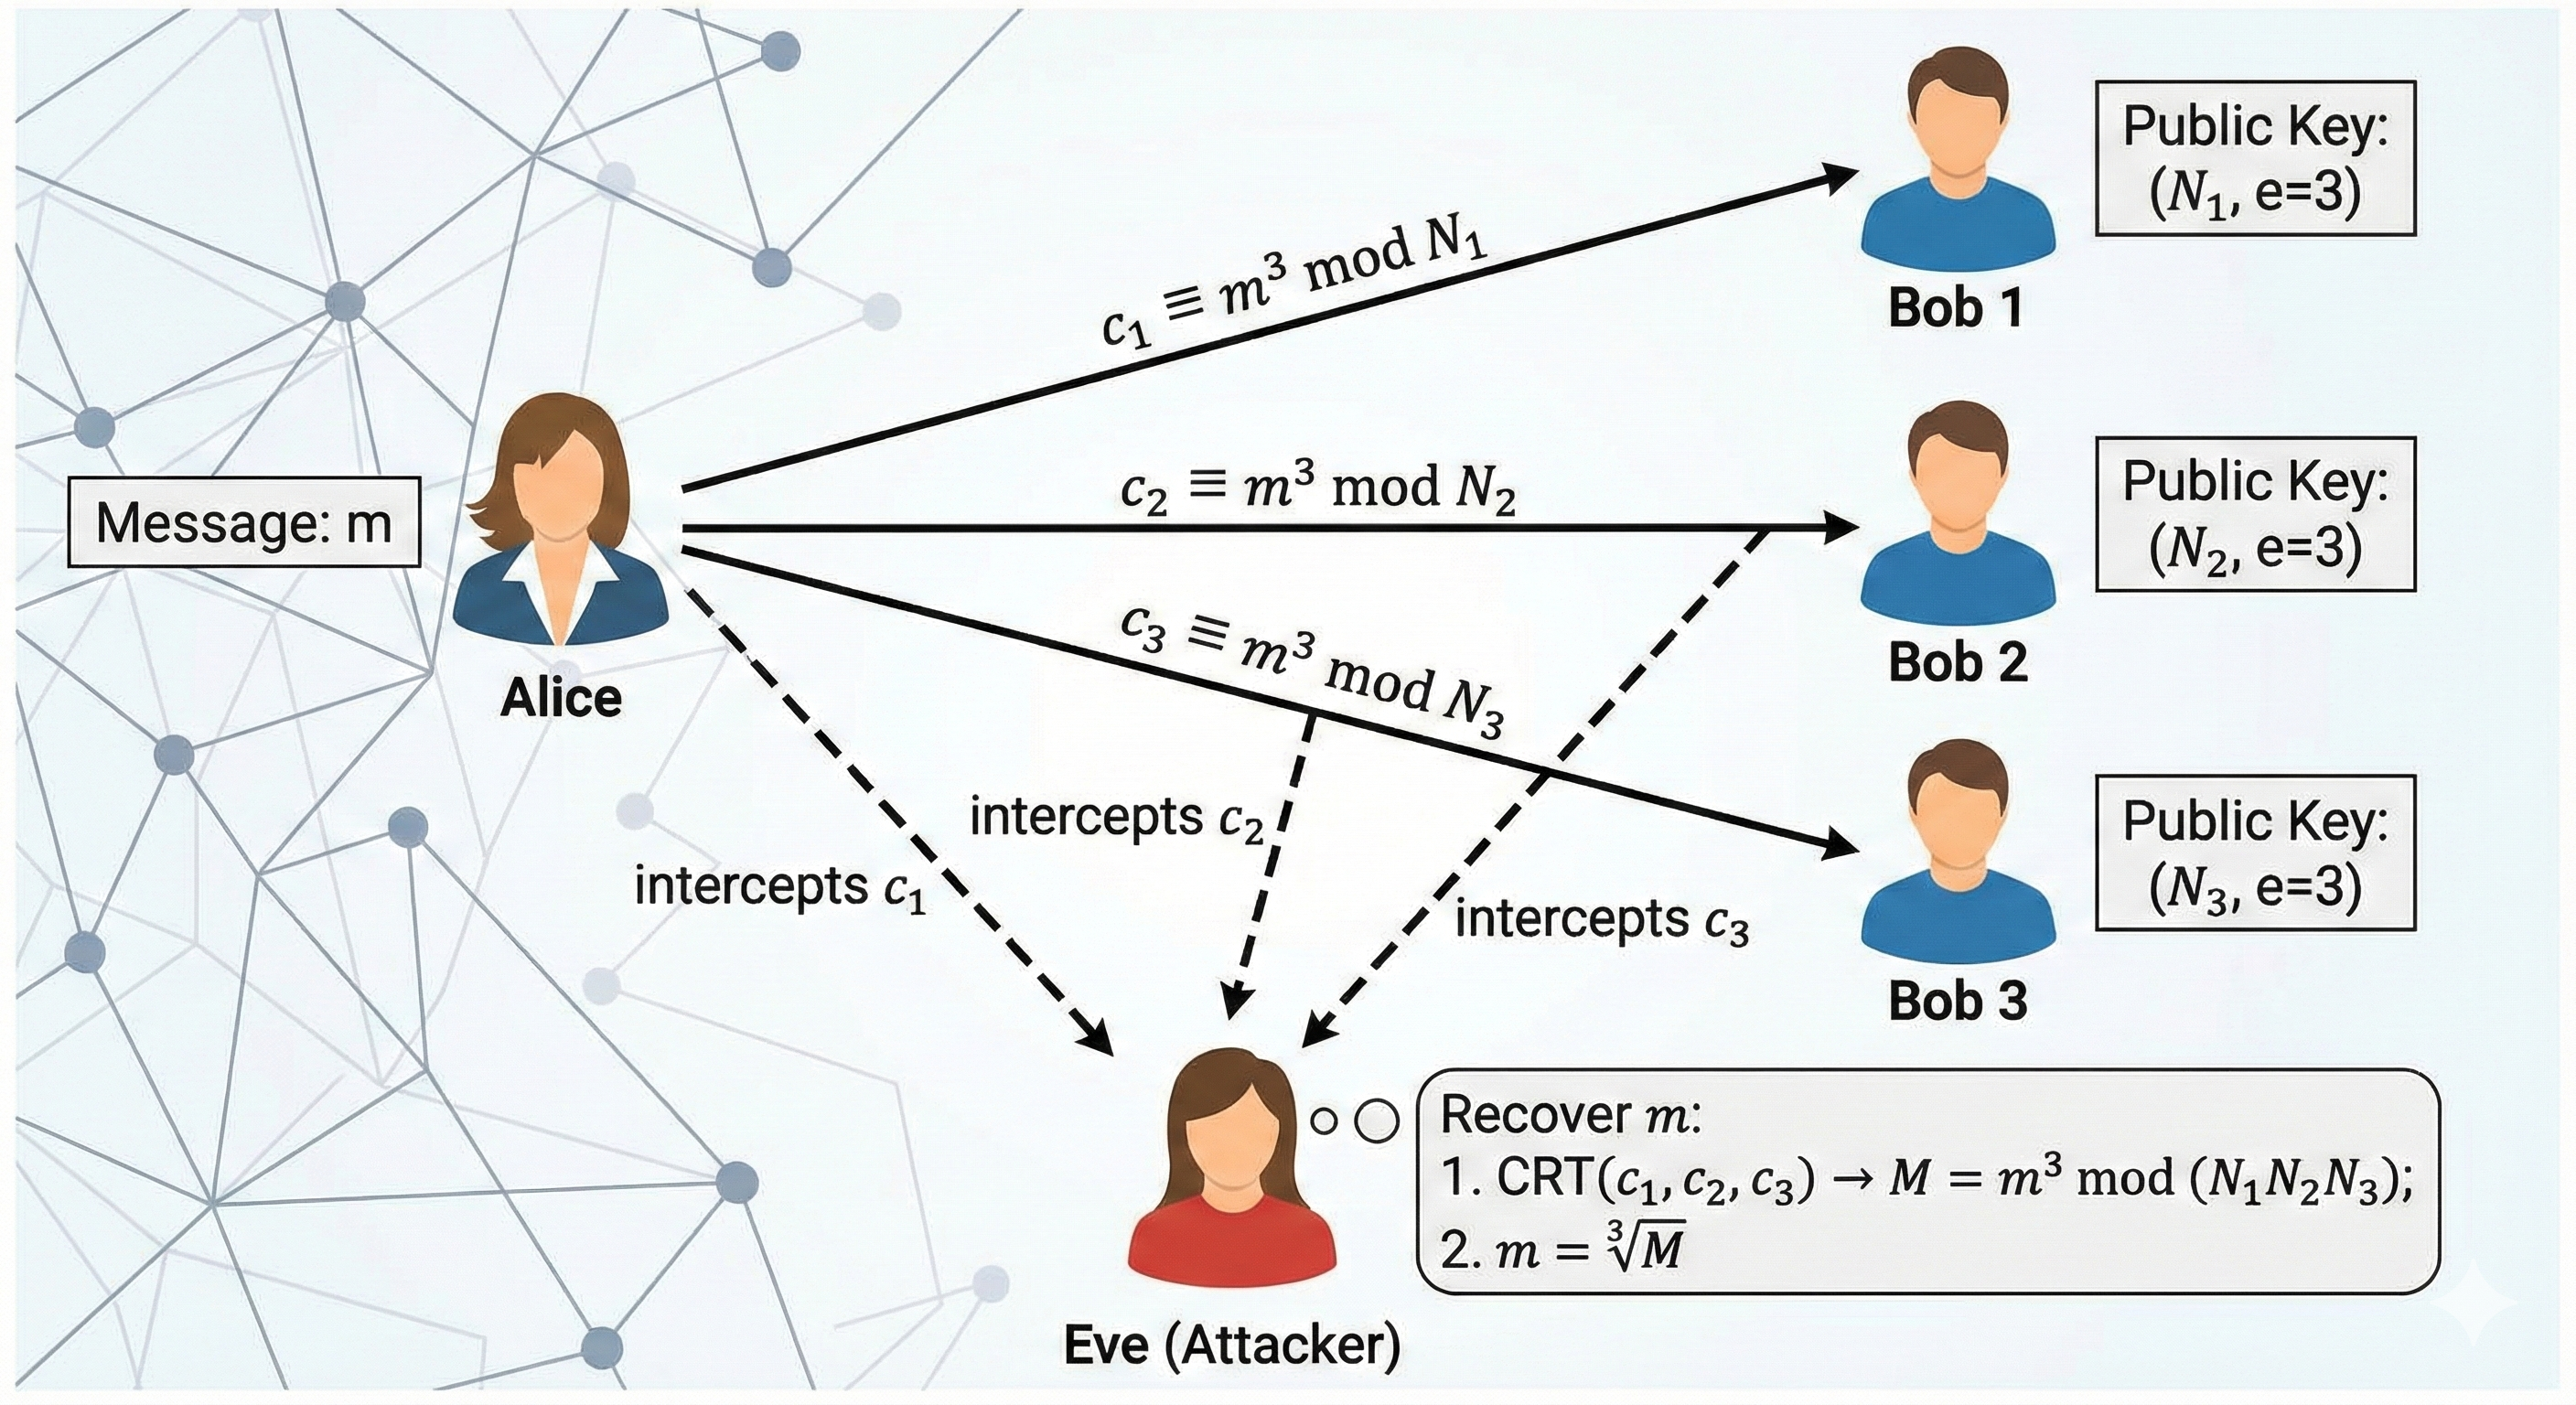

In [1]:
e = 3
N1, N2, N3 = 629, 2173, 1159
m = 25
c1, c2, c3 = [m**e % [N1, N2, N3][i] for i in range(3)]

### Saída da Interceptação
Neste ponto, o atacante interceptou os três cifrogramas. Observe que, embora a mensagem seja a mesma ($25$), os cifrogramas ($529, 414, 558$) parecem completamente aleatórios e diferentes entre si devido aos módulos distintos ($N$).

In [2]:
print(c1,c2,c3)

529 414 558


### O Sistema de Congruências

Como interceptamos o mesmo $m$ encriptado três vezes com o expoente $e=3$ $(c_1, c_2, c_3)$, e as assumindo que o atacante tem as chaves públicas dos remetentes, ele pode gerar o seguinte sistema de congruências:

$$
\begin{cases}
529 \equiv m^3 \pmod{629} \\
414 \equiv m^3 \pmod{2173} \\
558 \equiv m^3 \pmod{1159}
\end{cases}
$$

Por meio do **Teorema Chinês do Resto (CRT)** conseguimos calcular um valor $c$ também congruente a esse sistema mod $N1\cdot N2 \cdot N3$:

$$c \equiv m^3 \pmod{N_1 \cdot N_2 \cdot N_3}$$

Nos próximos blocos de código, vamos construir esse $c$ progressivamente.

### Passo 1:

Primeiramente vamos encontrar o menor valor congruente à primeira equivalência: $c_1 \equiv m^3 \pmod{N_1}$

Esse passo é trivial, pois o menor valor é o próprio **c1**, porém, como será necessário encontrar valores congruentes também às próximas equivalências, podemos gerar uma lista crescente dos valores congruentes por meio da seguinte função: $f(i) = c_1 + N_1 \cdot i$

In [3]:
c = [c1 + i*N1 for i in range(1000)]
print("Valores congruentes à primeira equivalência")
print(*c[:10],'...')

Valores congruentes à primeira equivalência
529 1158 1787 2416 3045 3674 4303 4932 5561 6190 ...


### Passo 2:

Agora, podemos iterar pela lista gerada no passo anterior para descobrir o menor valor congruente às duas primeiras equivalências do nosso sistema, para isso, basta encontrar o primeiro valor presente nela que também é congruente a $$ c2 \pmod{N_2} $$

In [4]:
for elem in c:
    if elem % N2 == c2:
        c = elem
        break
print("O menor valor que satisfaz ambas equivalências é:", c)

O menor valor que satisfaz ambas equivalências é: 15625


Com isso, podemos gerar a lista de valores congruentes a ambas simplesmente adicionando $ MMC(N1, N2) $ repetidas vezes ao valor calculado

Como no ataque em questão as chaves públicas devem ser coprimas, basta multiplicá-las para achar o mínimo múltiplo comum, assim, temos a seguinte função:
$$f(i) = c + N_1 \cdot N_2 \cdot i$$

In [5]:
c = [elem + i*(N1*N2) for i in range(1000)]
print("Valores congruentes à primeira e segunda equivalências")
print(*c[:10],'...')

Valores congruentes à primeira e segunda equivalências
15625 1382442 2749259 4116076 5482893 6849710 8216527 9583344 10950161 12316978 ...


### Passo 3:

Finalmente, podemos descobrir o menor valor congruente às três equivalências iterando pela lista gerada no passo anterior e comparando os valores com a terceira congruência

In [6]:
for elem in c:
    if elem % N3 == c3:
        c = elem
        break
print("O valor calculado é:",c)

O valor calculado é: 15625


### Como encontrar a  mensagem original?

O Teorema Chinês do Resto nos garante que o valor recuperado $C$ satisfaz:
$$C \equiv m^3 \pmod{N_1 \cdot N_2 \cdot N_3}$$

Isso significa matematicamente que:
$$C = m^3 + k \cdot (N_1 \cdot N_2 \cdot N_3)$$
Onde $k$ é um número inteiro (quantas vezes o valor "deu a volta" no módulo).

**O Pulo do Gato:**
Como a mensagem $m$ é sempre menor que qualquer um dos módulos $N$ (caso contrário, não poderíamos encriptar), e estamos usando 3 destinatários, temos a garantia de que:
$$m^3 < N_1 \cdot N_2 \cdot N_3$$

Isso implica que **$k = 0$**. Ou seja, o valor não "deu a volta" nenhuma vez. O número que recuperamos ($15625$) é o **próprio** $m^3$ em aritmética inteira normal, não modular.

Portanto, para descobrir a mensagem, basta tirar a **raiz cúbica real**:
$$m = \sqrt[3]{15625} = 25$$

In [7]:
plaintext = round(c**(1/e),5)
print("Mensagem decodificada:", plaintext)

Mensagem decodificada: 25.0


## Conclusão e Generalização

O exemplo acima ilustra uma vulnerabilidade grave no uso de RSA com **expoentes pequenos** e sem preenchimento aleatório (*padding*).

Embora tenhamos usado $e=3$ e interceptado 3 mensagens, o **Ataque de Broadcast de Håstad** funciona para **qualquer expoente $e$**, desde que o atacante consiga interceptar um número suficiente de textos cifrados.

### A Regra Geral

Para um expoente público $e$ qualquer, se o mesmo texto claro $m$ for enviado para $k$ destinatários diferentes (com módulos $N_1, N_2, \dots, N_k$ primos entre si), o ataque é bem-sucedido sempre que $k \ge e$. Ou seja, precisamos interceptar pelo menos tantas mensagens quanto o valor do expoente.

### Equações Generalizadas

O sistema de congruências interceptado pelo atacante se torna:

$$
\begin{cases}
c_1 \equiv m^e \pmod{N_1} \\
c_2 \equiv m^e \pmod{N_2} \\
\vdots \\
c_k \equiv m^e \pmod{N_k}
\end{cases}
$$

Pelo Teorema Chinês do Resto, calculamos um valor $C$ no módulo do produto de todos os $N$:

$$C \equiv m^e \pmod{N_1 \cdot N_2 \cdot \dots \cdot N_k}$$

Como $m < N_i$ para todo $i$, temos garantido que $m^e < \prod_{i=1}^{k} N_i$. Portanto, $C$ é exatamente igual a $m^e$ (sem redução modular), e a mensagem é recuperada simplesmente calculando a raiz $e$-ésima:

$$m = \sqrt[e]{C}$$

> **Nota de Segurança:** É por isso que implementações modernas de RSA usam expoentes maiores (como $e=65537$) e, crucialmente, utilizam esquemas de preenchimento como **OAEP**, que adicionam aleatoriedade à mensagem $m$ antes da encriptação, impedindo que $m$ seja idêntico para todos os destinatários.